<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Implement parallel computation of bifurcation map

In [ ]:
%%writefile task_5_test.py
#try to parralell
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from random import random
import time
#import os 
#os.environ["OMP_NUM_THREADS"] = "1"

def map_fun(r, x):
    return r*x*(1-x)

x_i = random()  #initial value of x
n = 200  #number of iterations
last = 200  #number of last values that we take into account
number_r = 10000

comm = MPI.COMM_WORLD #create a communicator
rank = comm.Get_rank() #rank of executing process
size = comm.Get_size() #gives number of ranks in comm
#print("my rank is ", rank)

t1 = MPI.Wtime()
r_values = np.linspace(0, 4, number_r)
r_list = np.array_split(r_values,size)[rank]
numDataPerRank = int((r_values.size)/size)

if(rank == 0):
    start = time.time()

#sendbuf = np.array([])
sendbuf = []
R = []
x_n = []
#for r in r_values[rank*numDataPerRank: (rank+1)*numDataPerRank]:
for r in r_list:
    x_i = random()
    for i in range(n+last):
        x_i = map_fun(r, x_i)
        if i >= n:
            x_n.append(x_i)
            R.append(r)


sendbuf = x_n
  
t2 = MPI.Wtime()        
#comm.Gather(sendbuf, recvbuf, root=0)
recieved_x = comm.gather(sendbuf,root=0) 
recieved_r = comm.gather(R,root=0) 

if rank == 0:
    recv_x = np.hstack(recieved_x) 
    recv_r = np.hstack(recieved_r)
    print('Time: {:.3f}s'.format(time.time() - start))
    #print('Rank: ',rank, ', recvbuf received: ',recvbuf, ', size', len(recvbuf))
    #fig = plt.figure()
    #plt.plot(recv_r, recv_x, ls='',marker=',')
    #plt.show()
    #fig.savefig('Bifurcation map with n = {} processes'.format(size))

Writing task_5_test.py


In [ ]:
! mpirun --allow-run-as-root -n 1 python3 task_5_test.py

Time: 8.310s


#Plot speedup vs number of processes

In [ ]:
time_arr = []
for i in range(1, 8):
    print(f'{i} process(es)\n\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_5_test.py
    time_arr.append(t.best)

1 process(es)
	Time: 8.110s
Time: 8.222s
Time: 8.418s
Time: 8.116s
10.1 s ± 117 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 process(es)
	Time: 4.809s
Time: 4.791s
Time: 4.839s
Time: 4.924s
6.46 s ± 55.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3 process(es)
	Time: 3.610s
Time: 3.646s
Time: 3.717s
Time: 3.599s
5.29 s ± 68.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 process(es)
	Time: 3.087s
Time: 3.143s
Time: 3.139s
Time: 3.144s
4.75 s ± 13.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
5 process(es)
	Time: 2.654s
Time: 2.665s
Time: 2.638s
Time: 2.676s
4.3 s ± 21 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 process(es)
	Time: 2.370s
Time: 2.452s
Time: 2.465s
Time: 2.427s
4.06 s ± 67 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
7 process(es)
	Time: 2.286s
Time: 2.212s
Time: 2.265s
Time: 2.195s
3.85 s ± 26.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 0.98, 'Speedup vs Np')

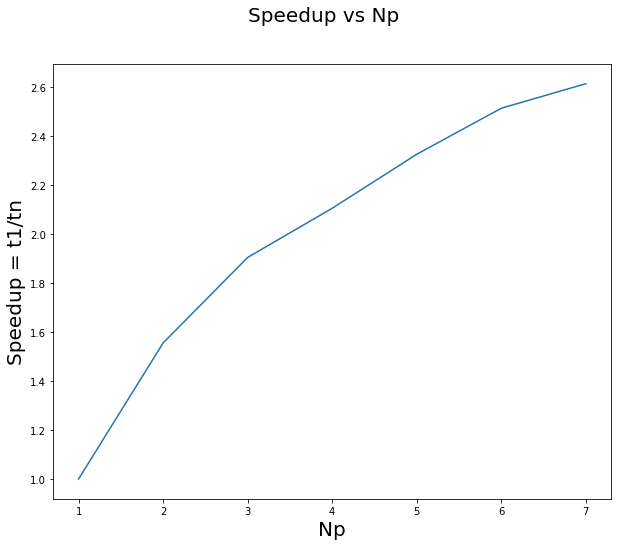

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

speedup = time_arr[0] / np.array(time_arr)
num_of_processes = range(1, 8)

plt.figure(figsize=(10, 8))
plt.plot(num_of_processes, speedup)
plt.xticks(num_of_processes)
plt.xlabel('Np', fontsize = 20)
plt.ylabel('Speedup = t1/tn', fontsize = 20)
plt.suptitle('Speedup vs Np', fontsize = 20)